อย่างที่เราทราบกันดีว่า I/O หรือระบบ Input/Output เป็นอะไรที่ช้าที่สุด ของระบบคอมพิวเตอร์ การที่จะ Optimize ให้คอมพิวเตอร์ทำงานได้ประสิทธิภาพมากที่สุด ต้องใช้ความรู้ความเข้าใจ บริหารจัดการทรัพยากรส่วนต่าง ๆ เช่น CPU, GPU, Memory, Storage ให้ทำงาน Utilize มากที่สุด ลด Bottleneck ที่ต้องรอข้อมูลระหว่างกัน

แต่ในการเทรน Machine Learning ที่เรากันอยู่ Training Loop จะเป็น อ่านข้อมูล, สับไพ่ข้อมูล, Split, Data Augmentation, Feed Forward, Loss Function, Backpropagation, Optimizer Update Weight แล้วเริ่มต้น Loop ใหม่ เป็นอย่างนี้ซ้ำ ๆ ไปเรื่อย ๆ ตามลำดับ โดยไม่ได้คำนึงประเด็นด้านบน

# Data Echoing

มี Paper ฉบับหนึ่ง ชื่อ Faster Neural Network Training with Data Echoing โดย Dami Choi, Alexandre Passos, Christopher J. Shallue, George E. Dahl เสนอแนวคิดง่าย ๆ ที่จะมาช่วยแก้ไขปัญหานี้ คือ Data Echoing แนวคิดคือเอา Data เดิมที่อยู่ในระบบอยู่แล้ว มาป้อนให้กับโมเดลใหม่ ระหว่างที่รอ Data ใหม่ ถึงแม้ว่าจะเป็น Data ที่โมเดลเพิ่งจะเห็นไป คุณภาพอาจจะไม่ดีเหมือน Data ใหม่ แต่ก็ดีกว่าปล่อยให้ โมเดล / GPU อยู่ว่าง ๆ 

ส่วนปัญหาที่ว่า Data เก่า ก็ให้ใช้ Data Augmentation เข้ามาช่วย ให้เหมือนกับว่าเป็น Data ใหม่อีก 1 Batch ซึ่งแนวคิดใน Paper มีอีกหลายวิธี จะอธิบายต่อไป



เราจะทดลองเปรียบเทียบกันแบบง่าย ๆ ระหว่าง Batch Size ขนาดต่าง ๆ เป็น Baseline และ ลดขนาด Batch Size ลงมา แต่เราจะเพิ่ม Data Echoing เข้าไปเสริม แล้วดูว่าโมเดลของเราจะ Converge เร็วขึ้นจริงหรือไม่

# 0. Magic Commands

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

เช็ค GPU ด้วย คำสั่ง [nvidia-smi](https://www.bualabs.com/archives/489/nvidia-smi-gpu-monitoring-tools-gpu-utilization-memory-usage-nvidia-hardware-ep-1/)

In [2]:
!nvidia-smi

Fri May 15 08:04:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Install & Import Library

In [3]:
!pip install fastai2 -q

     |████████████████████████████████| 194kB 5.0MB/s 


In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

# 2. Echoing Transform

ด้วยการออกแบบ DataBlock API ที่แสนยืดหยุ่นของ fastai2 ทำให้เราสามารถสร้าง Transform ไปแทรกใน Data Pipeline ก่อนที่จะ Feed ให้กับโมเดลได้อย่างเป็นระเบียบ และ Clean โดยเราจะสร้าง class EchoingTransform ที่ subclass มาจาก ItemTransform เพื่อเราจะไปใส่ไว้ใน batch_transform ก่อน Data Augmentation

In [0]:
class EchoingTransform(ItemTransform):
    order = 2
    split_idx = 0
    def __init__(self, e): self.e = e
    def encodes(self, x):
        img, lbl = x
        img = img.repeat(self.e, 1, 1, 1)
        lbl = lbl.repeat(self.e)
        # print(img.shape)
        # print(lbl.shape)
        return img, lbl

order = 2 เพราะต้องการให้ทำก่อน Data Augmentation และ split_idx = 0 คือ ให้ทำเฉพาะ Training Set

# 3. Dataset

In [6]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/"images")
pat = r"([^/]+)_\d+.*$"

# 4. DataBlock

กำหนดขนาดรูป

In [0]:
size = 224

สร้างฟังก์ชันสำหรับสร้าง DataLoaders

In [0]:
def get_dls(bs, e):
    item_tfms = RandomResizedCrop(300, min_scale=0.75, ratio=(1., 1.))
    batch_tfms = [EchoingTransform(e), *aug_transforms(size=size), Normalize.from_stats(*imagenet_stats)]
    pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                    get_items=get_image_files, 
                    splitter=RandomSplitter(), 
                    get_y=RegexLabeller(pat=r"/([^/]+)_\d+.*"), 
                    item_tfms=item_tfms, 
                    batch_tfms=batch_tfms)
    # pets.summary(path/"images")
    dls = pets.dataloaders(path/"images", bs=bs)
    return dls

In [9]:
Resize.order, EchoingTransform.order, IntToFloatTensor.order, Normalize.order

(1, 2, 10, 99)

ลองดูข้อมูลใน Batch ด้วย show_batch ด้วย Batch Size 4 และ Echoing 4 ครั้ง

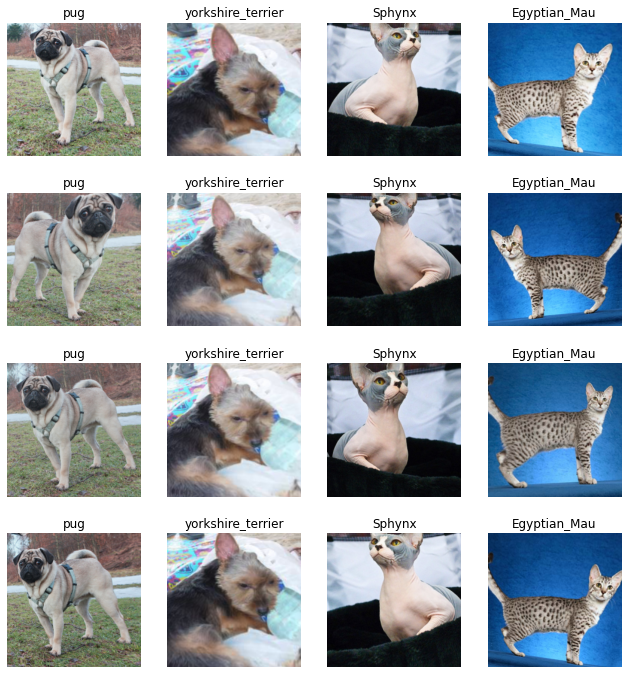

In [10]:
bs = 4
e = 4

dls = get_dls(bs, e)
dls.show_batch(max_n=16, figsize=(11, 12))

# 5. เปรียบเทียบ Echoing กับ Batch Size ต่าง ๆ 

## 5.1 No Echoing, bs=128

In [0]:
bs = 128
e = 1

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.830256,0.436433,0.135995,00:55
1,1.191529,0.268503,0.088633,00:55
2,0.651711,0.244096,0.081867,00:54
3,0.443875,0.241881,0.079838,00:53


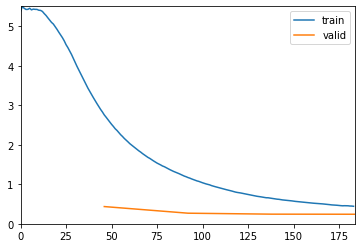

In [12]:
learn = cnn_learner(get_dls(bs, e), resnet34, metrics=error_rate, cbs=[ShowGraphCallback]).to_fp16()
learn.fit_one_cycle(4)

In [0]:
# learn.summary()

## 5.2 No Echoing, bs=64

In [0]:
bs = 64
e = 1

epoch,train_loss,valid_loss,error_rate,time
0,1.971881,0.349061,0.117727,00:55
1,0.701164,0.272049,0.082544,00:54
2,0.401522,0.249907,0.069689,00:54
3,0.291164,0.242951,0.069012,00:54


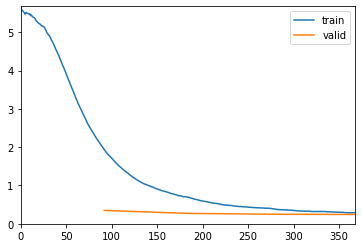

In [14]:
learn = cnn_learner(get_dls(bs, e), resnet34, metrics=error_rate, cbs=[ShowGraphCallback]).to_fp16()
learn.fit_one_cycle(4)

## 5.3 No Echoing, bs=32

In [0]:
bs = 32
e = 1

epoch,train_loss,valid_loss,error_rate,time
0,1.179628,0.357591,0.112314,01:00
1,0.464102,0.262548,0.089986,01:00
2,0.342443,0.245668,0.081191,01:01
3,0.298687,0.231545,0.070365,01:01


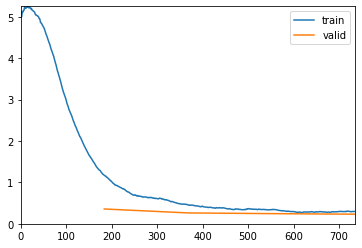

In [16]:
learn = cnn_learner(get_dls(bs, e), resnet34, metrics=error_rate, cbs=[ShowGraphCallback]).to_fp16()
learn.fit_one_cycle(4)

## 5.4 Echoing 2, bs=64

In [0]:
bs = 64
e = 2

epoch,train_loss,valid_loss,error_rate,time
0,1.769990,0.330970,0.101489,00:57
1,0.619998,0.239766,0.079161,00:57
2,0.337594,0.211292,0.066306,00:57
3,0.247905,0.208533,0.068336,00:58


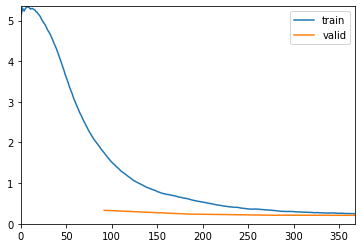

In [18]:
learn = cnn_learner(get_dls(bs, e), resnet34, metrics=error_rate, cbs=[ShowGraphCallback]).to_fp16()
learn.fit_one_cycle(4)

## 5.5 Echoing 4, bs=32

In [0]:
bs = 32
e = 4

epoch,train_loss,valid_loss,error_rate,time
0,0.992595,0.277852,0.094046,01:09
1,0.451004,0.221209,0.074425,01:09
2,0.276961,0.200764,0.061570,01:09
3,0.190032,0.191840,0.059540,01:09


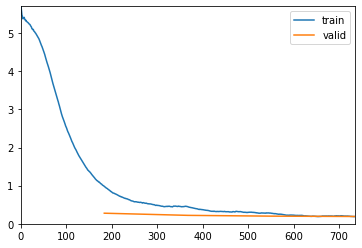

In [20]:
learn = cnn_learner(get_dls(bs, e), resnet34, metrics=error_rate, cbs=[ShowGraphCallback]).to_fp16()
learn.fit_one_cycle(4)

# 6. สรุป

* การ Echoing เหมือนกับเราใส่ข้อมูลเดิมเข้าไปให้โมเดลอีก e-1 รอบ ดังนั้น 1 Epoch ไม่ใช่การที่โมเดลเห็นข้อมูลครบทั้ง Dataset 1 รอบแล้ว กลายเป็น e รอบแทน
* ในเคส Echoing = 2 เวลาที่เพิ่มขึ้นมานิดหน่อย ต่อ 1 Epoch น้อยกว่าเวลาที่ใช้ในการเทรนปกติ 2 Epoch เพราะ GPU ทำงานเร็วกว่ามาก
* จากสถิติ Validation Loss จะเห็นว่า Echoing ช่วยให้โมเดล เทรนได้เร็วขึ้น ใช้เวลาน้อยลง Converge เร็วขึ้น 
* นี่เป็นเพียงการทดลองง่าย ๆ ใน Paper ยังมีแนวคิดอีกหลายเรื่อง จะอธิบายต่อไป


# Credit 

* https://arxiv.org/abs/1907.05550
* https://www.bualabs.com/archives/4102/tutorial-fastai2-oxford-pets-dog-cat-37-class-machine-learning-deep-neural-networks-image-classification-ep-7/